In [1]:
import numpy as np
from cztRoutines import *
import matplotlib.pyplot as plt

# What is the proper way of reconstructing the complex values from a tone's spectrum?

Here we outline the likely overlooked nuances of defining a closed-form equation for the spectrum of a given tone. Given a complex tone with frequency $f_0$ and amplitude $A$, with constant offset phase $\phi_0$ - that is, the tone typically given by

$$ x(t) = \exp(i 2 \pi f_0 t) \exp(i \phi)$$

what is the value of the spectrum formed by the _sampled_ tone at some point corresponding to $f$? If the first answer that comes to mind is that of the well known $sinc$ function, then one would only be half right. Here's the issue:

In [2]:
fs = 100.0
N = 100
f0 = 25.0
phi0 = 0.0
x = np.exp(1j*2*np.pi*f0*np.arange(N)/fs) * np.exp(1j*phi0)

fstep = 0.1
frange = 10.0
freqs = np.arange(f0-frange,f0+frange,fstep)

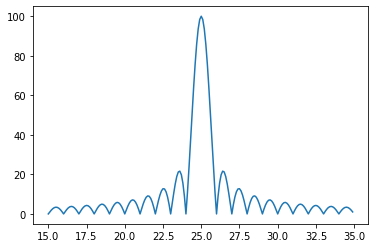

In [3]:
spectrum = dft(x,freqs,fs)
plt.plot(freqs, np.abs(spectrum))

All good so far. The plot obeys our well known $sinc$ function. As a primer, this is usually derived by considering how the windowing caused by taking a finite number of samples is equivalent to multiplication by a $rect$ function in time. Then by invoking convolution rules, we can show that this is equivalent to convolving with a $sinc$ (which is a Fourier transform of a $rect$) in frequency.

$$\mathcal{F}\{x(t) rect(t)\} = \mathcal{F}\{x(t)\} * \mathcal{F}\{rect(t)\}$$

Fourier transform of the tone $x(t)$ is a $\delta(f-f_0)$ function, so convolution over it produces the $sinc$ shape centred at $f_0$ as expected. The $sinc$ is _very typically_ derived like so:

$$
\begin{aligned}
\mathcal{F}\{rect(t)\} &= \int_{-\tau/2}^{\tau/2} e^{-i 2 \pi f t} dt\\
&= \tau \frac{\sin(\pi f \tau)}{\pi f \tau} \\
&= \tau sinc(f \tau)
\end{aligned}
$$

In other words, the $sinc$ envelope's max amplitude is given by the window length; in discrete terms, this equates to the number of samples, so we can write?

$$ NT sinc(f NT) $$

where $T = 1/f_s$, the period of the sample we selected. Convolution over the delta function is then given by

$$
(NT sinc(f NT)) * \delta(f-f_0) = \int NT sinc\left((f-f') NT\right) \delta(f'-f_0) df' = NT sinc((f-f_0) NT)
$$

which is what is expected: the $sinc$ function centred at $f_0$.

In discrete, sampled terms, the normalisation constant is actually just $N$ instead of $NT$. We can check this by simply considering the value of the DFT at $f_0$ itself:

$$
X(f_0) = \sum^{N-1}_{n=0} e^{i 2 \pi f_0 nT} e^{-i 2 \pi f_0 nT} = N
$$

Thus our final form for the $sinc$ function is really just 

$$
N sinc((f-f_0)NT)
$$

This corresponds nicely with what we obtained from directly DFT-ing the signal, as seen below.

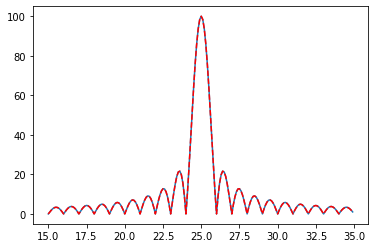

In [4]:
sincreal = N * np.sinc((freqs-f0)*N/fs)
plt.figure()
plt.plot(freqs, np.abs(spectrum))
plt.plot(freqs, np.abs(sincreal), 'r--')

But wait, what about the phase? Clearly, there was no phase in our derived $sinc$ function; it was completely real. But the DFT output __does__ have a phase.

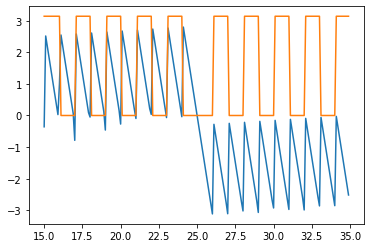

In [6]:
plt.figure()
plt.plot(freqs,np.angle(spectrum))
plt.plot(freqs,np.angle(sincreal)) # real, so the 'phase' has only two values: 0 and pi

How do we reconcile the derivation now? The answer is that the typical computational FFT/DFT routine does not treat the window symmetrically; the summation is actually taken over a window length __starting at 0 and ending at $\tau$__.

Instead of invoking convolution rules and _separately_ Fourier transforming the $rect$ function defined from $[-\tau/2,\tau/2]$,

$$
\int_{-\tau/2}^{\tau/2} e^{-i 2 \pi f t} dt
$$

it is simpler now to just consider the integral we are looking for directly, using a $rect$ function defined from $[0,\tau]$,

$$
\int_0^{\tau} e^{i 2 \pi f_0 t} e^{-i 2 \pi f t} dt = - i \tau \frac{1 - e^{-i 2 \pi (f - f_0) \tau}}{2 \pi (f-f_0) \tau}
$$

Clearly, the previous $sinc$ function got the amplitude right, so it must be buried in here:

$$
\begin{aligned}
- i \tau \frac{1 - e^{-i 2 \pi (f - f_0) \tau}}{2 \pi (f-f_0) \tau} &= -i\tau e^{-i \pi (f-f_0) \tau} \frac{e^{i \pi (f-f_0) \tau} - e^{-i \pi (f - f_0) \tau}}{2 \pi (f-f_0) \tau}\\
&= -i \tau e^{-i \pi (f-f_0) \tau} \frac{ \sin(\pi (f-f_0) \tau) (2i)}{2 \pi (f-f_0) \tau} \\
&= \left[e^{-i \pi (f-f_0) \tau}\right] \left[\tau \frac{\sin(\pi (f-f_0) \tau)}{\pi (f-f_0) \tau}\right] \\
&= \left[e^{-i \pi (f-f_0) \tau}\right] \left[sinc((f-f_0) \tau)\right]
\end{aligned}
$$

So there it is. The phase here has resulted completely from taking an asymmetric integral starting from 0, rather than taking it equally on both sides of 0. The amplitude is unaffected, but the phase is now given by 

$$\theta = - \pi (f-f_0) \tau$$

or in discrete, sampled terms,

$$\theta = - \pi (f-f_0) N T$$


In [ ]:
theta = -np.pi*(freqs-f_0) * N * 1/fs
